# SC2 Professional Matches Replay Data Dive
## Jeffrey Kwarsick, Ph.D.
### August 2020

### References
1. https://miguelgondu.github.io/python/ai/video%20games/2018/09/04/a-tutorial-on-sc2reader-events-and-units.html
2. https://lauler.github.io/blog/replay/
3. https://sc2reader.readthedocs.io/en/latest/
4. https://lotv.spawningtool.com/replaypacks/
5. https://github.com/GraylinKim/sc2reader

In [2]:
# import relevant libraries
import os
import numpy as np
import scipy as sci
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import pandas as pd
from scipy.optimize import curve_fit
import sklearn
import re
import seaborn as sns
import math
from datetime import datetime
####################################
import sc2reader

In [3]:
os.getcwd()

'C:\\Users\\stark\\Documents\\Coding\\SC2'

In [5]:
os.listdir()

['.ipynb_checkpoints',
 'FirstSC2Dive_Aug2020.ipynb',
 'IEM Katowice 2020 - Replays',
 'IEM Katowice 2020 - Server Qualifiers replaypack',
 'NA S1 - Clem vs soO G1 - World of Sleepers LE.SC2Replay',
 'NA S1 - Clem vs soO G2 - Eternal Empire LE.SC2Replay',
 'NA S1 - Clem vs soO G3 - Triton LE.SC2Replay',
 'SC2Maps',
 'Untitled.ipynb']

Loading in a single replay in order to begin exploring they type of data stored by the replay

In [6]:
replay = sc2reader.load_replay('NA S1 - Clem vs soO G1 - World of Sleepers LE.SC2Replay', load_map=True)

Below is some code from Reference (1) to sort events in replay by type.  Through the `sc2reader` package.  Events from the replay are stored within `replay.events`
- `event_names` creates a set of all types of events stored in the replay
- `events_of_type` stores all events of a particular type

In [9]:
event_names = set([event.name for event in replay.events])
events_of_type = {name: [] for name in event_names}
for event in replay.events:
    events_of_type[event.name].append(event)

In [11]:
event_names

{'AddToControlGroupEvent',
 'BasicCommandEvent',
 'CameraEvent',
 'ChatEvent',
 'ControlGroupEvent',
 'GetControlGroupEvent',
 'PlayerLeaveEvent',
 'PlayerSetupEvent',
 'PlayerStatsEvent',
 'ProgressEvent',
 'SelectionEvent',
 'SetControlGroupEvent',
 'TargetPointCommandEvent',
 'TargetUnitCommandEvent',
 'UnitBornEvent',
 'UnitDiedEvent',
 'UnitDoneEvent',
 'UnitInitEvent',
 'UnitPositionsEvent',
 'UnitTypeChangeEvent',
 'UpdateTargetPointCommandEvent',
 'UpdateTargetUnitCommandEvent',
 'UpgradeCompleteEvent',
 'UserOptionsEvent'}

In [78]:
events_of_type['UnitDiedEvent']

Extracting unit death information from a single replay
- `.unit` is the unit and it's unique id for the game
- `.killer` is player owner of the killing unit
- `.killing_unit` is the killing unit of the unit that has been killed
- `.x` and `.y` are the position coordinates where the unit died
- `.second` is the second in which the unit was killed
- `.frame` the frame in which the unit died (perhaps more accurate)

In [75]:
def extract_unit_death_info(UnitDiedEventList):
    # take list containing unit death information and extract all relevant info
    # returns a dataframe containing the following
    # UNIT, KILLER (Player), KILLING UNIT, (x,y) POSITIONS, FRAME, SECOND
    unit_died_events = UnitDiedEventList
    udied_unit    = [unit_died_events[i].unit for i in range(len(unit_died_events))]
    udied_killer  = [unit_died_events[i].killer for i in range(len(unit_died_events))]
    udied_killingu= [unit_died_events[i].killing_unit for i in range(len(unit_died_events))]
    udied_coord_x = [unit_died_events[i].x for i in range(len(unit_died_events))]
    udied_coord_y = [unit_died_events[i].y for i in range(len(unit_died_events))]
    udied_coord_fr = [unit_died_events[i].frame for i in range(len(unit_died_events))]
    udied_coord_t = [unit_died_events[i].second for i in range(len(unit_died_events))]
    unit_death_df = pd.DataFrame(list(zip(udied_unit, udied_killer, udied_killingu, 
                                      udied_coord_x, udied_coord_y, udied_coord_fr, udied_coord_t)))
    unit_death_df.columns = ['Unit', 'UnitKiller', 'KillingUnit', 'x', 'y', 'Frame', 't']
    return(unit_death_df)

In [23]:
unit_death_df = pd.DataFrame(list(zip(udied_unit, udied_killer, udied_killingu, 
                                      udied_coord_x, udied_coord_y, udied_coord_t, udied_coord_fr)))
unit_death_df.columns = ['Unit', 'UnitKiller', 'KillingUnit', 'x', 'y', 't', 'frame']
unit_death_df

Unit             UnitKiller          KillingUnit    x  \
0         Larva [3700001]                   None                 None  149   
1         Larva [3780001]                   None                 None  148   
2         Larva [3740001]                   None                 None  150   
3         Larva [3B00001]                   None                 None  149   
4         Larva [3BC0001]                   None                 None  149   
...                   ...                    ...                  ...  ...   
1458        SCV [5980006]  Player 2 - soO (Zerg)  Ultralisk [8380013]   34   
1459        SCV [60C000C]  Player 2 - soO (Zerg)   Zergling [BA8000B]   35   
1460        SCV [5540007]  Player 2 - soO (Zerg)   Zergling [8C0000C]   34   
1461  Liberator [AF80003]  Player 2 - soO (Zerg)   Mutalisk [750000B]   47   
1462        SCV [6D80004]  Player 2 - soO (Zerg)  Ultralisk [8380013]   32   

        y     t  frame  
0     138    18    289  
1     138    40    654  
2     138    43    689  
3     138    60    968  
4     138    60    971  
...   ...   ...    ...  
1458   53  1351  21623  
1459   58  1352  21632  
1460   60  1352  21643  
1461   57  1352  21643  
1462   51  1353  21649  

[1463 rows x 7 columns]

In [97]:
def extract_upgrade_complete(UpgradeCompleteEventList):
    """
    func to extract information regarding upgrade complete events
    :param = UpgradeCompleteEventList
    :out   = Dataframe(PID, PLAYER, NAME OF UPGRADE, FRAMES)
    """
    pid    = [UpgradeCompleteEventList[i].pid for i in range(len(UpgradeCompleteEventList))]
    player = [UpgradeCompleteEventList[i].player for i in range(len(UpgradeCompleteEventList))]
    NoU    = [UpgradeCompleteEventList[i].upgrade_type_name for i in range(len(UpgradeCompleteEventList))]
    frms   = [UpgradeCompleteEventList[i].frame for i in range(len(UpgradeCompleteEventList))]
    upgrade_complete = pd.DataFrame(list(zip(pid,player,NoU,frms)))
    upgrade_complete.columns = ['PID', 'Player', 'Name of Upgrade', 'Frames']
    return(upgrade_complete)

In [98]:
extract_upgrade_complete(events_of_type['UpgradeCompleteEvent'])

PID                    Player              Name of Upgrade  Frames
0     1  Player 1 - Clem (Terran)           RewardDanceStalker       0
1     1  Player 1 - Clem (Terran)             RewardDanceGhost       0
2     1  Player 1 - Clem (Terran)              RewardDanceMule       0
3     1  Player 1 - Clem (Terran)            RewardDanceViking       0
4     2     Player 2 - soO (Zerg)          RewardDanceOverlord       0
5     2     Player 2 - soO (Zerg)           RewardDanceStalker       0
6     2     Player 2 - soO (Zerg)             RewardDanceRoach       0
7     2     Player 2 - soO (Zerg)            RewardDanceOracle       0
8     2     Player 2 - soO (Zerg)              RewardDanceMule       0
9     2     Player 2 - soO (Zerg)          RewardDanceInfestor       0
10    1  Player 1 - Clem (Terran)              GameHeartActive       0
11    2     Player 2 - soO (Zerg)              GameHeartActive       0
12    1  Player 1 - Clem (Terran)                  SprayTerran       0
13    1  Player 1 - Clem (Terran)                  SprayTerran       0
14    2     Player 2 - soO (Zerg)                    SprayZerg       0
15    2     Player 2 - soO (Zerg)                    SprayZerg       0
16    2     Player 2 - soO (Zerg)                    SprayZerg    1075
17    1  Player 1 - Clem (Terran)                  SprayTerran    2199
18    2     Player 2 - soO (Zerg)                    SprayZerg    2675
19    2     Player 2 - soO (Zerg)                    SprayZerg    3189
20    1  Player 1 - Clem (Terran)                  SprayTerran    3799
21    2     Player 2 - soO (Zerg)                    SprayZerg    4789
22    2     Player 2 - soO (Zerg)        zerglingmovementspeed    5417
23    1  Player 1 - Clem (Terran)                  SprayTerran    5938
24    1  Player 1 - Clem (Terran)                  SprayTerran    8471
25    1  Player 1 - Clem (Terran)                     Stimpack    8707
26    2     Player 2 - soO (Zerg)                    SprayZerg    9489
27    1  Player 1 - Clem (Terran)                   ShieldWall   10759
28    2     Player 2 - soO (Zerg)          GlialReconstitution   10871
29    2     Player 2 - soO (Zerg)                    SprayZerg   11089
30    2     Player 2 - soO (Zerg)                    SprayZerg   11577
31    1  Player 1 - Clem (Terran)  TerranInfantryWeaponsLevel1   11589
32    1  Player 1 - Clem (Terran)   TerranInfantryArmorsLevel1   12168
33    2     Player 2 - soO (Zerg)       ZergGroundArmorsLevel1   12332
34    2     Player 2 - soO (Zerg)                    SprayZerg   13177
35    2     Player 2 - soO (Zerg)             CentrificalHooks   13232
36    1  Player 1 - Clem (Terran)                  SprayTerran   13326
37    2     Player 2 - soO (Zerg)       ZergMeleeWeaponsLevel1   13417
38    2     Player 2 - soO (Zerg)                    SprayZerg   14467
39    1  Player 1 - Clem (Terran)                  SprayTerran   14926
40    1  Player 1 - Clem (Terran)  TerranInfantryWeaponsLevel2   14997
41    1  Player 1 - Clem (Terran)   TerranInfantryArmorsLevel2   15422
42    2     Player 2 - soO (Zerg)       ZergGroundArmorsLevel2   15787
43    2     Player 2 - soO (Zerg)                    SprayZerg   16067
44    2     Player 2 - soO (Zerg)                    SprayZerg   16109
45    2     Player 2 - soO (Zerg)       ZergFlyerWeaponsLevel1   17672
46    2     Player 2 - soO (Zerg)                    SprayZerg   17709
47    2     Player 2 - soO (Zerg)                    SprayZerg   17748
48    2     Player 2 - soO (Zerg)       ZergMeleeWeaponsLevel2   18144
49    1  Player 1 - Clem (Terran)   TerranVehicleWeaponsLevel1   18307
50    2     Player 2 - soO (Zerg)          zerglingattackspeed   18856
51    1  Player 1 - Clem (Terran)  TerranInfantryWeaponsLevel3   19296
52    2     Player 2 - soO (Zerg)                    SprayZerg   19348
53    2     Player 2 - soO (Zerg)       ZergGroundArmorsLevel3   20126
54    2     Player 2 - soO (Zerg)             ChitinousPlating   20625
55    1  Player 1 - Clem (Te

In [24]:
uks = unit_death_df['UnitKiller'].unique()
uks

array([None, Player 1 - Clem (Terran), Player 2 - soO (Zerg)],
      dtype=object)

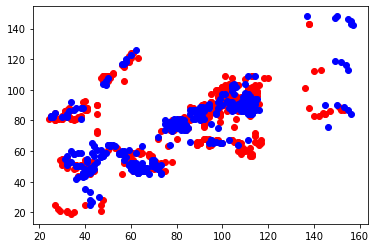

In [27]:
plt.plot('x', 'y', 'ro', data=unit_death_df.loc[unit_death_df['UnitKiller'] == uks[1]])
plt.plot('x', 'y', 'bo', data=unit_death_df.loc[unit_death_df['UnitKiller'] == uks[2]])
plt.show()

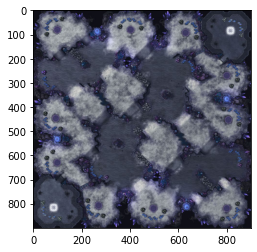

In [28]:
cwd = os.getcwd()
os.chdir(cwd + "\\SC2Maps")
img = plt.imread("World_of_Sleepers_LE.jpg")
fig, ax = plt.subplots()
ax.imshow(img)

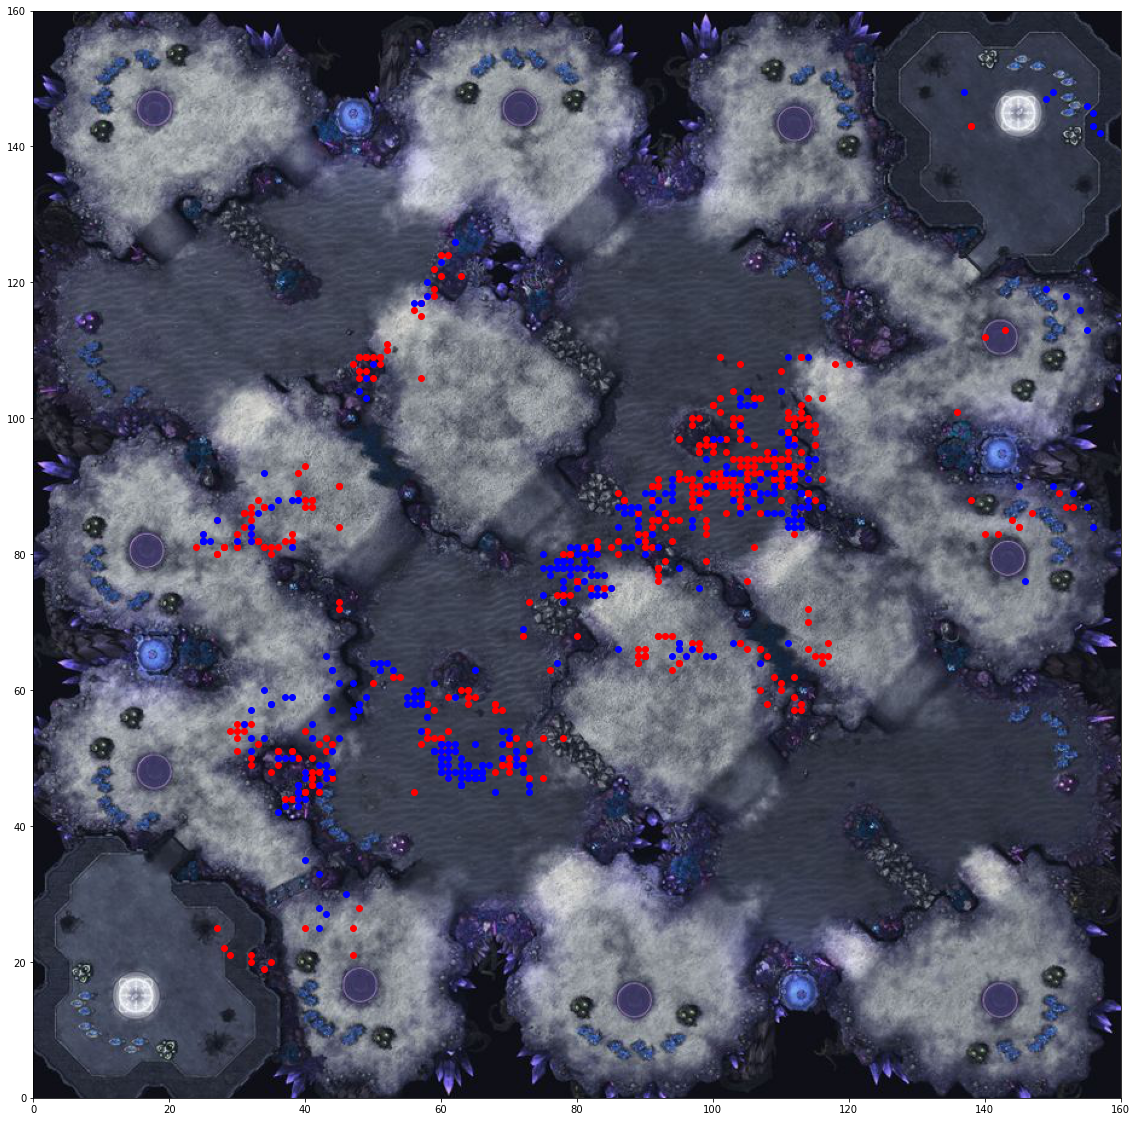

In [31]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img, extent=[0, 160, 0, 160])
ax.plot('x', 'y', 'ro', data=unit_death_df.loc[unit_death_df['UnitKiller'] == uks[1]])
ax.plot('x', 'y', 'bo', data=unit_death_df.loc[unit_death_df['UnitKiller'] == uks[2]])

Looking at workers

In [58]:
workers_p1 = [x for x in events_of_type['UnitBornEvent'] if x.control_pid==1 and x.unit.is_worker]
workers_p2 = [x for x in events_of_type['UnitBornEvent'] if x.control_pid==2 and x.unit.is_worker]
print("P1 Workers = {}\nP2 Workers = {}".format(len(workers_p1), len(workers_p2)))

P1 Workers = 115
P2 Workers = 119


In [60]:
worker_deaths_p1 = [x for x in events_of_type['UnitDiedEvent'] if x.killer==replay.players[1] and x.unit.is_worker]
worker_deaths_p2 = [x for x in events_of_type['UnitDiedEvent'] if x.killer==replay.players[0] and x.unit.is_worker]
print("P1 Worker Deaths = {}\nP2 Worker Deaths = {}".format(len(worker_deaths_p1), len(worker_deaths_p2)))

P1 Worker Deaths = 65
P2 Worker Deaths = 27


In [61]:
worker_deaths_p1

In [77]:
p1_wrkr_deaths = extract_unit_death_info(worker_deaths_p1)
p1_wrkr_deaths

Unit             UnitKiller          KillingUnit   x   y  Frame  \
0   SCV [5000002]  Player 2 - soO (Zerg)    Ravager [5DC0001]  43  59   7339   
1   SCV [4CC0001]  Player 2 - soO (Zerg)    Ravager [5E40001]  44  57   7473   
2   SCV [3B40001]  Player 2 - soO (Zerg)      Roach [53C0004]  41  55   7503   
3   SCV [4A00002]  Player 2 - soO (Zerg)   Zergling [5740003]  35  58   7529   
4   SCV [5E80001]  Player 2 - soO (Zerg)   Zergling [5340001]  37  59   7532   
..            ...                    ...                  ...  ..  ..    ...   
60  SCV [7480002]  Player 2 - soO (Zerg)   Zergling [BA8000B]  65  47  21339   
61  SCV [5980006]  Player 2 - soO (Zerg)  Ultralisk [8380013]  34  53  21623   
62  SCV [60C000C]  Player 2 - soO (Zerg)   Zergling [BA8000B]  35  58  21632   
63  SCV [5540007]  Player 2 - soO (Zerg)   Zergling [8C0000C]  34  60  21643   
64  SCV [6D80004]  Player 2 - soO (Zerg)  Ultralisk [8380013]  32  51  21649   

       t  
0    458  
1    467  
2    468  
3    470  
4    470  
..   ...  
60  1333  
61  1351  
62  1352  
63  1352  
64  1353  

[65 rows x 7 columns]

In [72]:
p1_wrkr_deaths['Unit'].unique()

array([SCV [5000002], SCV [4CC0001], SCV [3B40001], SCV [4A00002],
       SCV [5E80001], SCV [4E40004], SCV [5780001], MULE [67C0002],
       SCV [5240005], SCV [5700003], MULE [5C40002], SCV [5080004],
       SCV [5A40002], SCV [5E00002], SCV [5D00004], SCV [50C0002],
       SCV [41C0001], SCV [3740007], SCV [62C0002], SCV [5F40005],
       SCV [5700005], SCV [5700006], SCV [8A00002], SCV [7740003],
       SCV [7700001], SCV [3C00001], SCV [8380002], SCV [34C0001],
       SCV [9700006], SCV [3C80001], SCV [3F40001], SCV [4300001],
       SCV [6D4000B], SCV [85C0002], SCV [8900001], SCV [4740006],
       SCV [7CC0002], SCV [7E00001], SCV [3680001], SCV [8240001],
       SCV [4280002], SCV [45C0001], SCV [3500001], SCV [640002],
       SCV [7D80003], SCV [9700011], SCV [7000006], SCV [3580001],
       SCV [7100001], SCV [3480001], SCV [6300001], SCV [940000F],
       SCV [B5C0010], SCV [950000F], SCV [46C0002], SCV [6C80004],
       MULE [A180004], SCV [65C0002], SCV [780002], SCV [7080

In [76]:
p2_wrkr_deaths = extract_unit_death_info(worker_deaths_p2)
p2_wrkr_deaths

Unit                UnitKiller               KillingUnit    x  \
0    MULE [3740005]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   40   
1    MULE [4740002]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   32   
2    MULE [4B00002]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   36   
3    MULE [5400002]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   33   
4    MULE [4100002]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   32   
5   Drone [6280002]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  145   
6   Drone [658000B]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  144   
7   Drone [5500001]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  142   
8   Drone [5540001]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  145   
9   Drone [6680001]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  147   
10  Drone [5180002]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  152   
11  Drone [6700001]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  153   
12  Drone [6240009]  Player 1 - Clem (Terran)   Battlecruiser [6880001]  151   
13   MULE [540000B]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   30   
14   MULE [6940009]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   31   
15   MULE [4A0000A]  Player 1 - Clem (Terran)  OrbitalCommand [4FC0003]   31   
16   MULE [70C0001]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   36   
17   MULE [4500006]  Player 1 - Clem (Terran)  OrbitalCommand [4FC0003]   61   
18   MULE [8500001]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   60   
19   MULE [1D00003]  Player 1 - Clem (Terran)  OrbitalCommand [4FC0003]   60   
20   MULE [37C0027]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   60   
21   MULE [5F40011]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   61   
22   MULE [62C000D]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   30   
23   MULE [9D00003]  Player 1 - Clem (Terran)  OrbitalCommand [3380001]   31   
24   MULE [7C00005]  Player 1 - Clem (Terran)  OrbitalCommand [4FC0003]   33   
25   MULE [6CC0012]  Player 1 - Clem (Terran)  OrbitalCommand [3F80002]   35   
26   MULE [7F0000A]  Player 1 - Clem (Terran)  OrbitalCommand [4FC0003]   60   

     y  Frame     t  
0   25   4050   253  
1   21   5463   341  
2   51   5996   374  
3   52   6962   435  
4   55   7375   460  
5   84   8459   528  
6   85   8474   529  
7   83   8501   531  
8   84   8531   533  
9   86   8561   535  
10  87   8599   537  
11  87   8620   538  
12  89   8652   540  
13  54   9858   616  
14  55  10197   637  
15  54  10763   672  
16  51  11202   700  
17  52  12269   766  
18  51  13126   820  
19  52  13681   855  
20  51  16097  1006  
21  49  16101  1006  
22  83  17711  1106  
23  84  17713  1107  
24  82  17912  1119  
25  80  18718  1169  
26  51  21018  1313

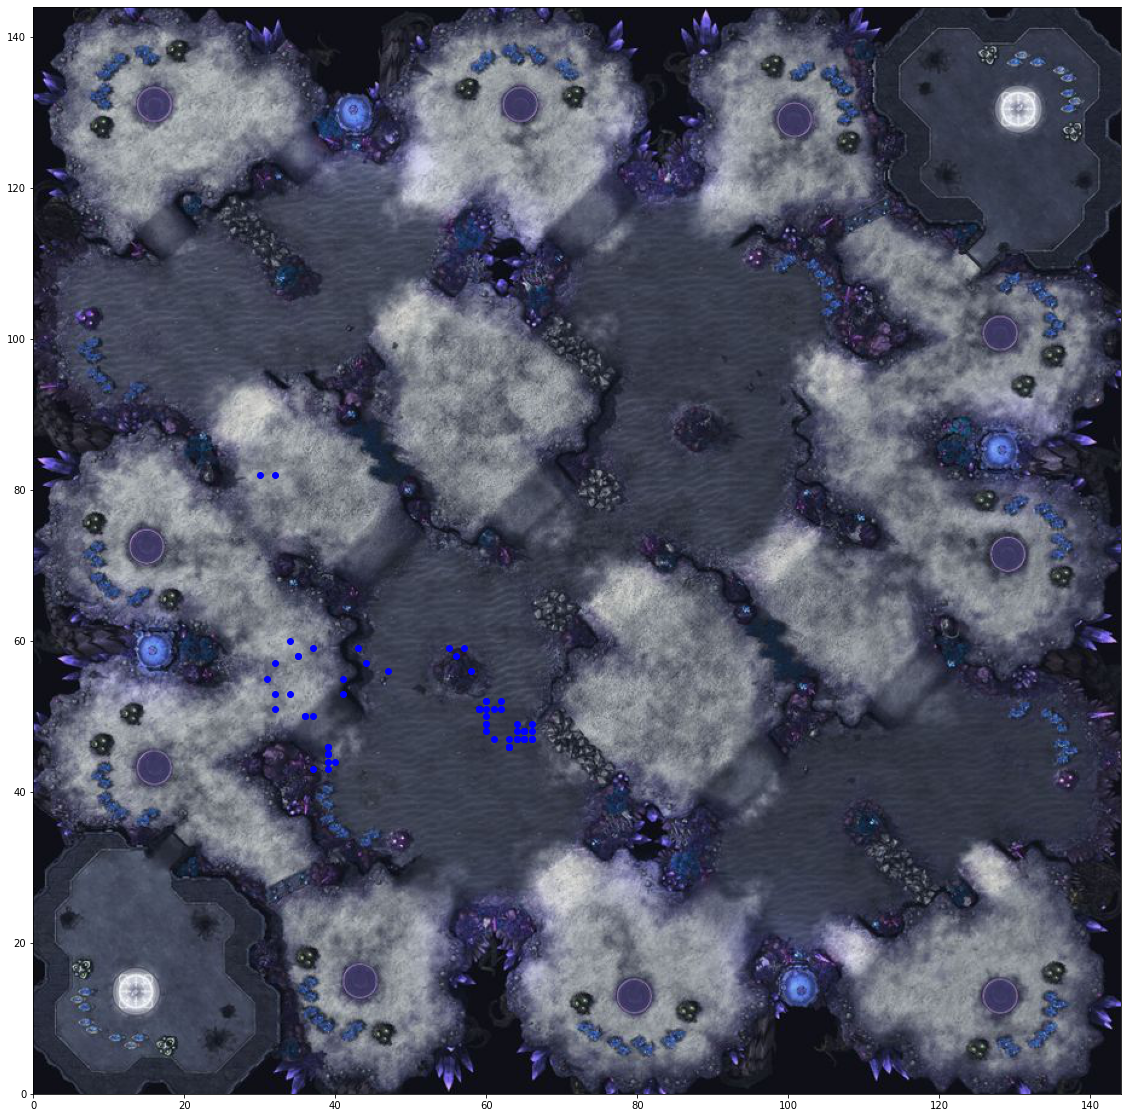

In [68]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img, extent=[0, 144, 0, 144])
ax.plot('x', 'y', 'bo', data=p1_wrkr_deaths)